In [1]:
from searchtweets import ResultStream, gen_rule_payload, load_credentials, collect_results

# general imports
import numpy as np
import pandas as pd
#import tweepy
from textblob import TextBlob
import re
import time
import datetime

# plotting and visualization
import matplotlib
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#S2_Date = pd.read_csv('tweets_2018-08-01_2018-08-15_Date.csv', names=['Date'], parse_dates=['Date'])
#S2_Tweets = pd.read_csv('tweets_2018-08-01_2018-08-15_Tweets.csv', names=['Tweets'])

# parse_dates failed, added extra code to coerce dates into datetime format. Due to adding column to df...
S2_meta = pd.read_csv('tweets_2018-0916_2018-0930_Metadata.csv', 
                      header=0, 
                      parse_dates=['date'], encoding = 'latin1')
#S2_meta = S2_meta.assign(date = pd.to_datetime(S2_meta['date'], infer_datetime_format=True, errors='coerce' ))
S2_tweets = pd.read_csv('tweets_2018-0916_2018-0930_Tweets.csv', header=0, encoding = 'latin1')
S2 = pd.concat([S2_tweets, S2_meta], axis=1)

In [3]:
S2.tail()

,tweets,date,user_name,user_screen_name,user_followers,user_friends,user_verified,user_language,retweet_count,favorite_count
11995,While hardly any development is going on with ...,2018-09-30 20:57:20,Escrow,escrow_ms,167,127,False,en,0,1
11996,RT @Tyan2042: #CoinEx Listing Issue ââï¸â...,2018-09-30 20:57:19,Konstantin,odhingood,5663,4312,False,ru,0,0
11997,@_tm3k ð buys STD with fake bitcoin,2018-09-30 20:57:18,MaxLeverage,MaxLeverage200,1422,1438,False,en,0,2
11998,@fulmolightning Nice date bitcoin was released...,2018-09-30 20:57:17,Litecoin Master ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½[LTC 8k,xtdisnkfe,1024,295,False,en,0,1
11999,RT @T21094: The virtual currency Oct. Coin is ...,2018-09-30 20:57:16,ýýýýýýýýýýýýýýý,8zAXGL52N1wyz9f,147,476,False,ja,0,0


In [4]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    
    textblob already has a trained analyser to work 
    with different machine learning models on 
    natural language processing.
    
    Might want to train our own model
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1
    

def sentiment_analysis(S2):
    # We create a column with the result of the analysis:
    S2['SA'] = np.array([ analize_sentiment(tweet) for tweet in S2['tweets'] ])
    
    # We construct lists with classified tweets:
    pos_tweets = [ tweet for index, tweet in enumerate(S2['tweets']) if S2['SA'][index] > 0]
    neu_tweets = [ tweet for index, tweet in enumerate(S2['tweets']) if S2['SA'][index] == 0]
    neg_tweets = [ tweet for index, tweet in enumerate(S2['tweets']) if S2['SA'][index] < 0]

    # We print percentages:
    print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(S2['tweets'])))
    print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(S2['tweets'])))
    print("Percentage de negative tweets: {}%".format(len(neg_tweets)*100/len(S2['tweets'])))

In [5]:
sentiment_analysis(S2)

Percentage of positive tweets: 36.516666666666666%
Percentage of neutral tweets: 53.06666666666667%
Percentage de negative tweets: 10.416666666666666%


In [6]:
#S2['rounded_day'] = S2['date'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
S2['rounded_hour'] = S2['date'].dt.round('H')

In [7]:
S3_A = S2.groupby(['rounded_hour']).agg('count').reset_index()
S3 = S2.groupby(['rounded_hour', 'SA']).agg('count').reset_index()
S3 = S3.assign(count = S3['tweets']).loc[:,['rounded_hour', 'SA', 'count']]
S3_pivot = S3.pivot(index = 'rounded_hour', columns='SA', values='count')

In [8]:
S3_pivot.head()

SA,-1,0,1
rounded_hour,,,
2018-09-16 00:00:00,7,63,30
2018-09-16 03:00:00,9,53,38
2018-09-16 06:00:00,11,55,34
2018-09-16 09:00:00,15,52,33
2018-09-16 12:00:00,15,50,35


In [9]:
'''cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])]
'''

def plot_stacked_bar(df, x, y, nrows=1, ncols=1):
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, dpi=1200)
    #fig, ax = plt.subplots()
    
    #ax.plot(df[x], df[y], '.')
    df.plot.bar(stacked=True, ax=ax, colormap='Spectral')
    
    # Make most of the ticklabels empty so the labels don't get too crowded
    ticklabels = ['']*len(df.index)
    # Every 5th ticklable shows the month and day
    ticklabels[::8] = [item.strftime('%m.%d') for item in df.index[::8]]
    # Every 12th ticklabel includes the year
    #ticklabels[::12] = [item.strftime('%b %d\n%Y') for item in df.index[::12]]
    plt.style.use('ggplot')
    ax.legend(loc=0)
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    plt.gcf().autofmt_xdate()
    
    #fig.savefig('stacked_bar_chart_SA.png')
    #plt.close()
    plt.show()

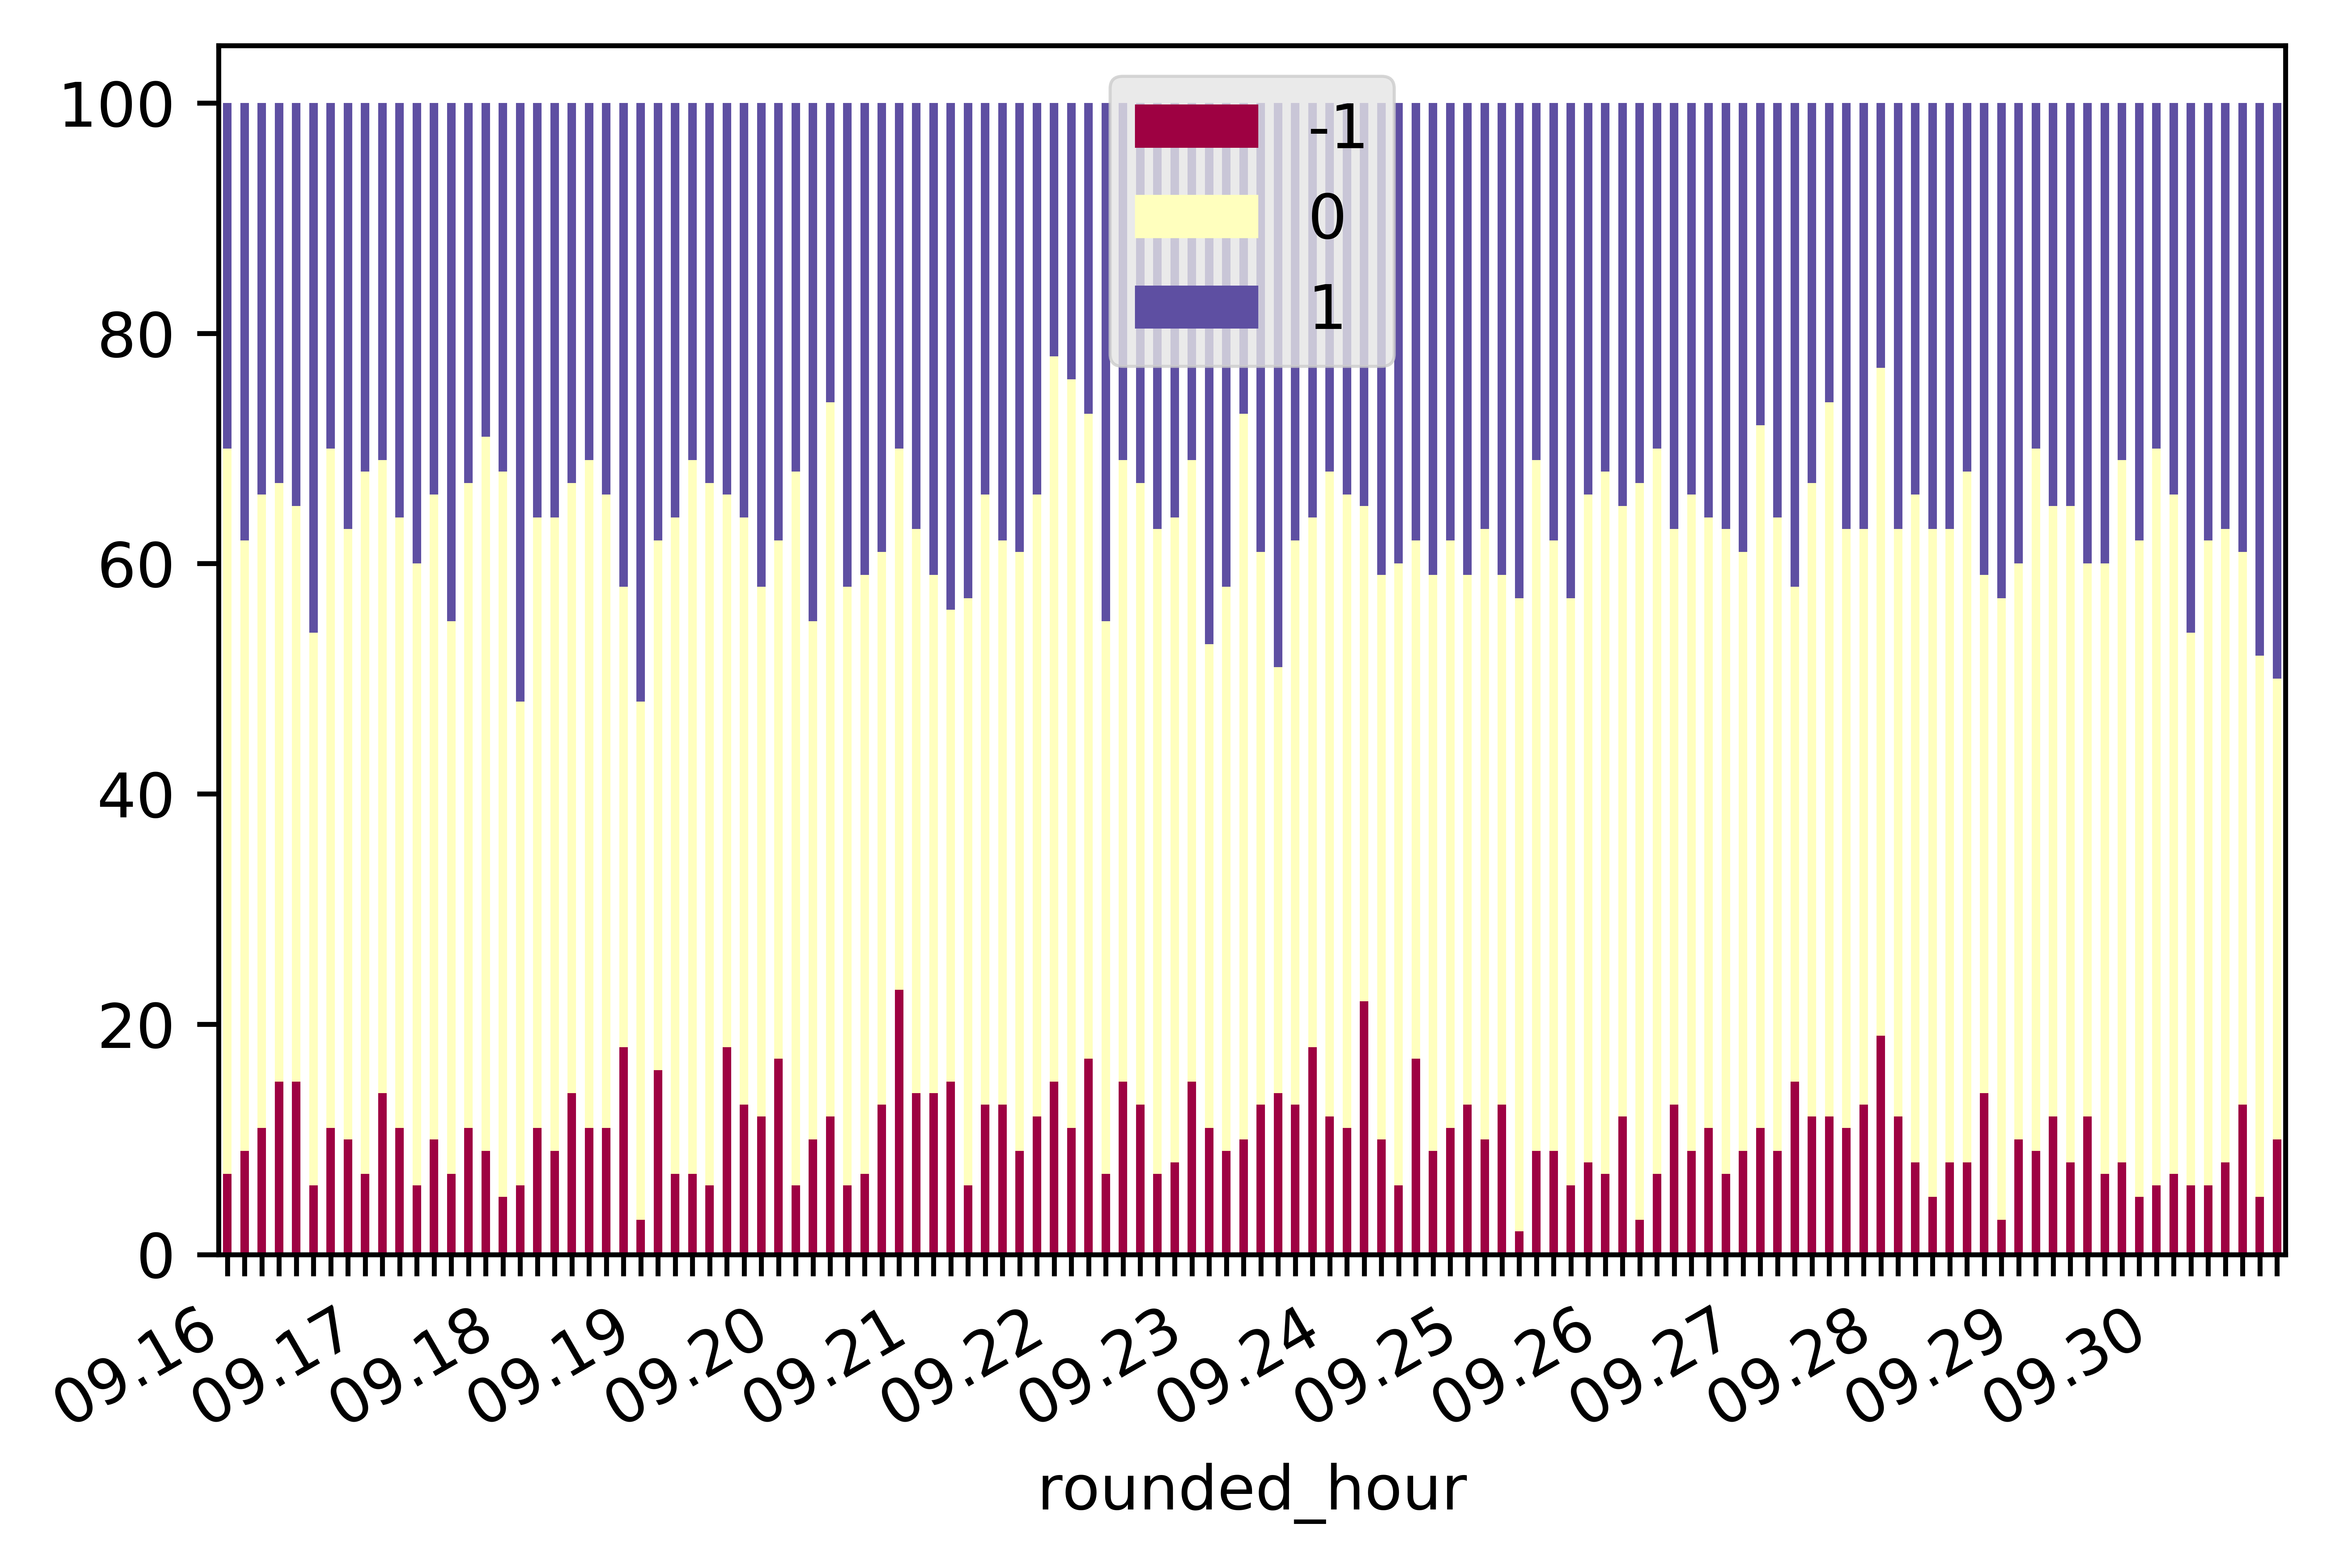

In [10]:
plot_stacked_bar(S3_pivot, 'rounded_hour', 'SA')

In [40]:
S3_pivot.tail()
# import csv
# # S3_pivot.values.tolist()
S3_pivot.to_csv('S3_df.csv')
# with open('S3_df.csv', 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(S3_pivot)

# csvFile.close()
# S3_pivot.head()

#S3_pivot.unique().to_csv("S3_pivot.csv", index=True)

#type(S3_pivot)
